Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [20]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [21]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [22]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/ISIC/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/ISIC/Test')

In [23]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [24]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [25]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.


In [26]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [27]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

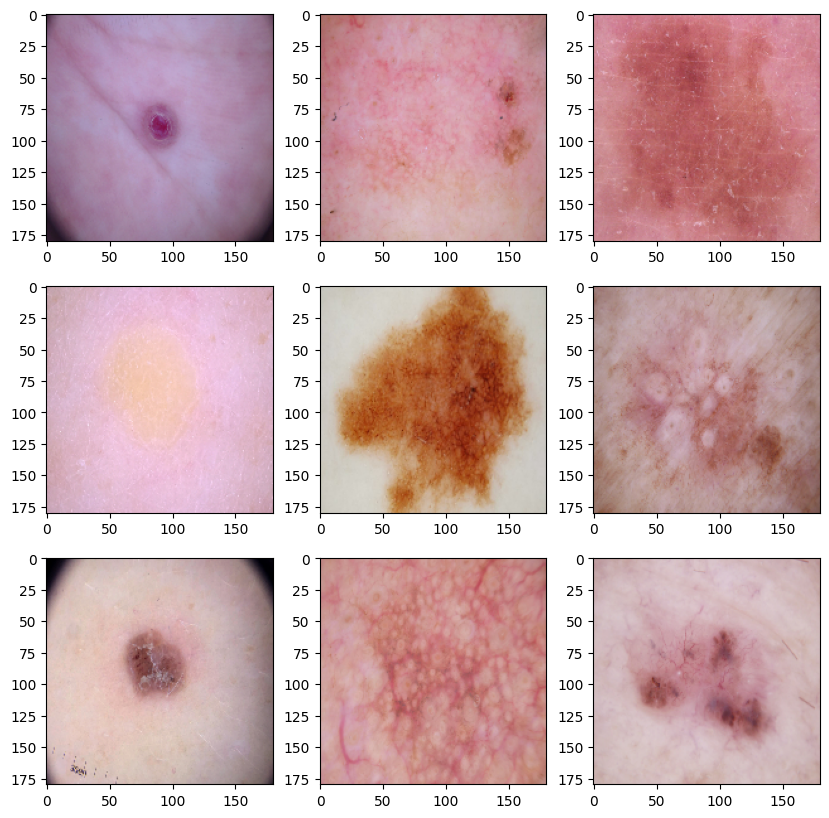

In [28]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [30]:
### Your code goes here
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Changed from layers.experimental.preprocessing.Rescaling
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(9,activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [31]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [32]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [33]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 355s 136ms/step - accuracy: 0.2068 - loss: 2.1051 - val_accuracy: 0.4094 - val_loss: 1.6088
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4225 - loss: 1.5802 - val_accuracy: 0.5570 - val_loss: 1.3286
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4968 - loss: 1.3758 - val_accuracy: 0.5369 - val_loss: 1.2903
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5410 - loss: 1.2657 - val_accuracy: 0.5772 - val_loss: 1.1663
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5760 - loss: 1.1792 - val_accuracy: 0.6242 - val_loss: 1.0903
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6062 - loss: 1.1097 - val_accuracy: 0.5794 - val_loss: 1.1583
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6161 - loss: 1.0713 - val_accuracy: 0.6823 - val_loss: 0.9240
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6649 - loss: 0.9282 - val_accuracy: 0.6644 

### Visualizing training results

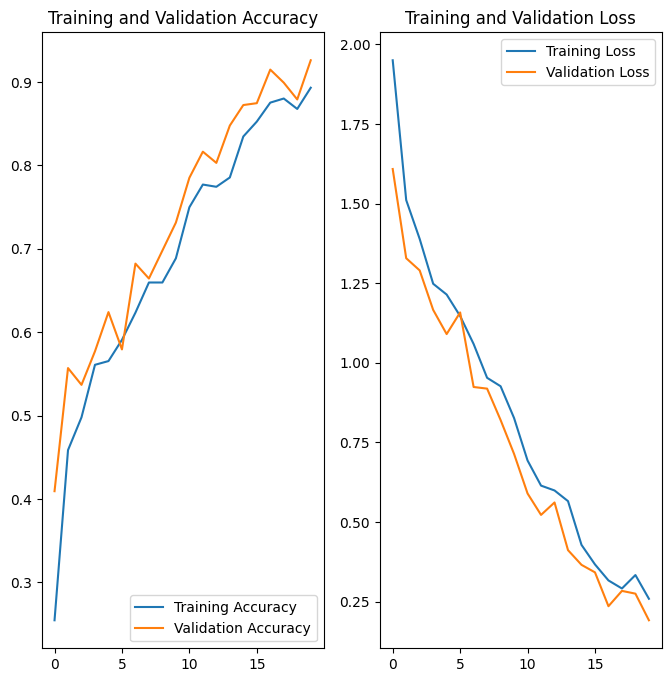

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


1. Training & Validation Accuracy Trends
The training accuracy improves steadily from 22.87% (epoch 1) to 89.15% (epoch 20).
The validation accuracy also increases from 36.91% to 89.93%.
The two accuracy curves remain close to each other, which is a good sign—indicating that the model is generalizing well.


2. Training & Validation Loss Trends
The training loss decreases from 2.11 to 0.27, showing that the model is learning.
The validation loss also drops from 1.79 to 0.25.
The validation loss does not increase sharply at the end, which suggests that the model is not overfitting significantly.


3. Checking for Overfitting
Overfitting occurs when the training accuracy is very high, but validation accuracy stops improving or starts decreasing.
Here, training and validation accuracy remain close throughout, which means no strong overfitting is present.
However, by epoch 17-20, training accuracy is higher than validation accuracy (89.15% vs. 89.93%), so mild overfitting might be starting.


4. Checking for Underfitting
Underfitting happens when both training and validation accuracy remain low or the model fails to learn patterns.
Since accuracy improves significantly over time (from ~20% to ~90%), there is no sign of underfitting.


5. Possible Improvements
Even though the model is performing well, some fine-tuning can help:
Data Augmentation – Helps improve generalization & reduce overfitting
Regularization (Dropout, L2 Regularization) – Can prevent overfitting in later epochs.


### Write your findings here

In [35]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),  # Randomly flip images horizontally
    layers.RandomRotation(0.2),  # Rotate images by ±20% of 360°
    layers.RandomZoom(0.1),  # Zoom images randomly by 10%
    layers.RandomContrast(0.2),  # Adjust contrast by ±20%
    layers.RandomTranslation(0.1, 0.1)  # Translate images randomly by 10% in both directions
])

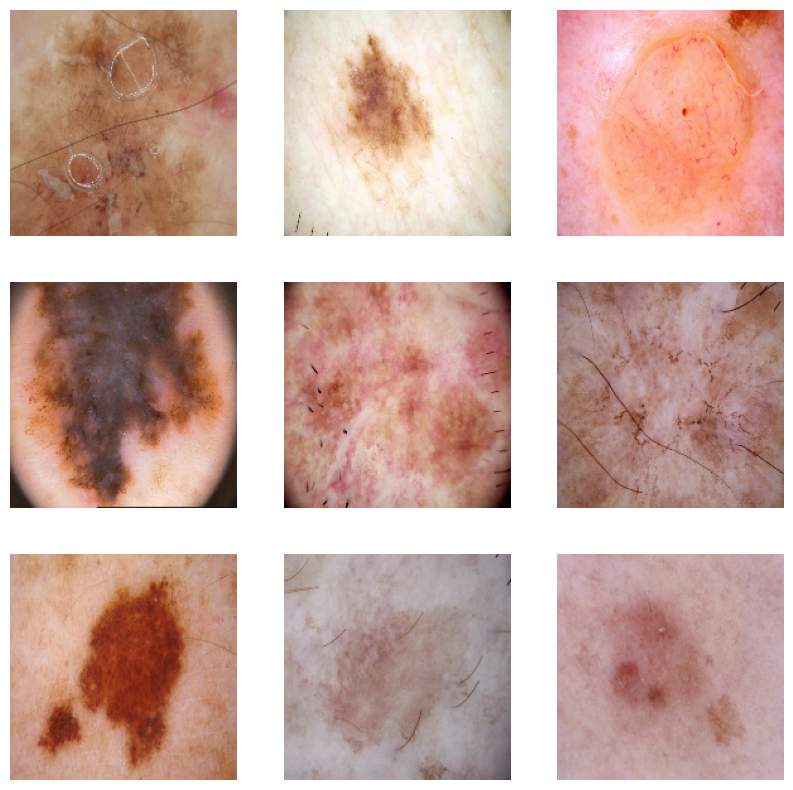

In [36]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Take a batch from the dataset
    for i in range(9):  # Display first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to uint8 image
        plt.axis("off")  # Hide axes
    break  # Stop after one batch
plt.show()

### Todo:
### Create the model, compile and train the model


In [37]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes her
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalize pixel values

    # First convolutional block
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Second convolutional block
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Third convolutional block
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),

    # Fully connected layer with Dropout to prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout with 50% rate

    layers.Dense(9, activation='softmax')  # Softmax for multi-class classification
])

### Compiling the model

In [38]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Since we used softmax
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [39]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.1867 - loss: 2.1770 - val_accuracy: 0.2304 - val_loss: 1.9266
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3097 - loss: 1.9383 - val_accuracy: 0.4161 - val_loss: 1.7146
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3690 - loss: 1.7624 - val_accuracy: 0.4094 - val_loss: 1.6373
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3974 - loss: 1.6745 - val_accuracy: 0.4497 - val_loss: 1.4854
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4424 - loss: 1.5970 - val_accuracy: 0.4944 - val_loss: 1.4881
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4616 - loss: 1.5286 - val_accuracy: 0.5034 - val_loss: 1.4080
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4868 - loss: 1.4509 - val_accuracy: 0.5570 - val_loss: 1.2665
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5043 - loss: 1.3895 - val_accuracy: 0.5839 - v

### Visualizing the results

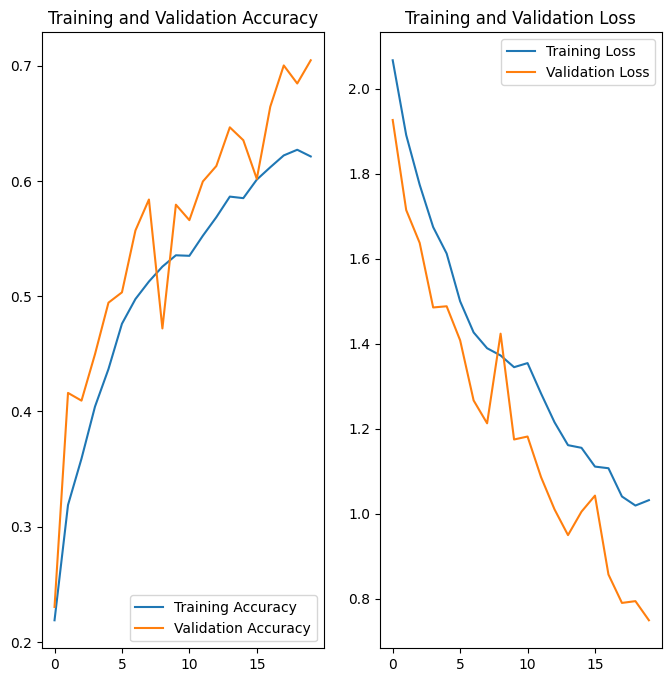

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

No significant overfitting observed: Training and validation accuracy are close to each other throughout the epochs.
Validation accuracy surpasses training accuracy in later epochs, which is not typical of overfitting. This could indicate that the model learns better representations or that regularization is effective.
Loss curves are decreasing steadily for both training and validation, which is a good sign.

Yes, the validation accuracy has improved compared to the previous model run.
The training and validation loss curves are more aligned, suggesting the Dropout layer helped in reducing overfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

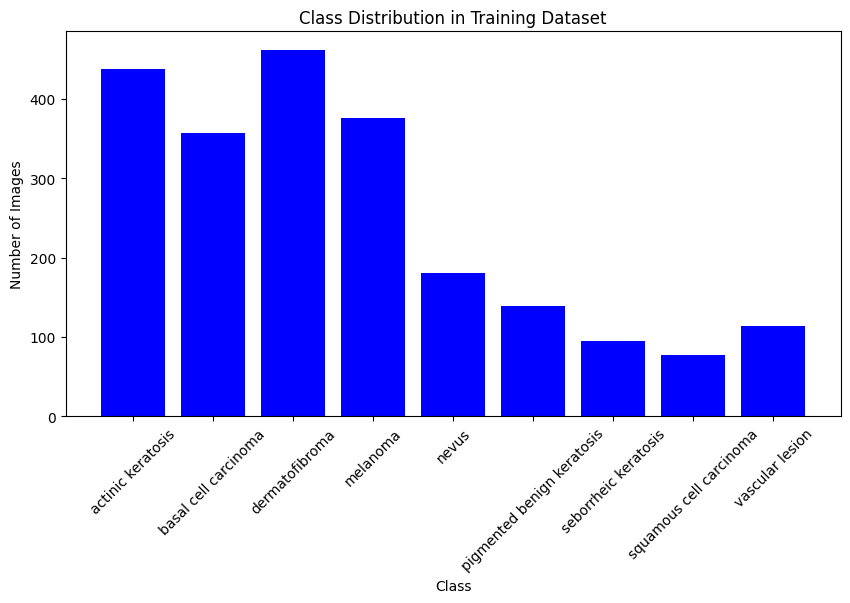

In [41]:
## Your code goes here.
from collections import Counter
class_names = class_names
# Counting occurrences of each class in the training dataset
class_counts = Counter()
for images, labels in train_ds:
  class_counts.update(labels.numpy())

# Plot class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts.values(), color='blue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=45)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?

squamous cell carcinoma

#### - Which classes dominate the data in terms proportionate number of samples?

Dermatofibroma


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [42]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [43]:
from pathlib import Path
path_to_training_dataset = Path("/content/drive/MyDrive/Colab Notebooks/ISIC/Train")
import Augmentor


for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset / i))  # Convert to string
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A6A32277450>: 100%|██████████| 500/500 [00:25<00:00, 19.72 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ISIC/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A6A322921D0>: 100%|██████████| 500/500 [00:16<00:00, 29.54 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A6AA771B850>: 100%|██████████| 500/500 [00:19<00:00, 26.19 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7A6A321576D0>: 100%|██████████| 500/500 [01:25<00:00,  5.82 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ISIC/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7A6A29743650>: 100%|██████████| 500/500 [01:15<00:00,  6.63 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A6A296428D0>: 100%|██████████| 500/500 [00:17<00:00, 28.57 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ISIC/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7A6A295BA2D0>: 100%|██████████| 500/500 [00:37<00:00, 13.20 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A6A325E2B10>: 100%|██████████| 500/500 [00:17<00:00, 29.36 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A6A321576D0>: 100%|██████████| 500/500 [00:17<00:00, 28.10 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [44]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [45]:
import glob
import os
from pathlib import Path

data_dir_train = Path("/content/drive/MyDrive/Colab Notebooks/ISIC/Train")
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(path_list)

['/content/drive/MyDrive/Colab Notebooks/ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033705.jpg_7592c67d-37f1-4b79-9aec-f43fd93c1c45.jpg', '/content/drive/MyDrive/Colab Notebooks/ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026984.jpg_192b3a58-abb3-46b6-9fbf-6f0214000a34.jpg', '/content/drive/MyDrive/Colab Notebooks/ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026212.jpg_84ae96a9-0b6c-4b50-8a6e-c2e3ca4a76c6.jpg', '/content/drive/MyDrive/Colab Notebooks/ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027562.jpg_fd65b110-93b9-457e-9b9f-c168dc2bd039.jpg', '/content/drive/MyDrive/Colab Notebooks/ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_5c2ffdf3-cb4e-4316-aaaa-70e6d266de88.jpg', '/content/drive/MyDrive/Colab Notebooks/ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026729.jpg_1223df86-1393-4eb2-8618-42a7a109e091.jpg', '/content/drive/MyDri

In [46]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [47]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [48]:
path_list_all = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_all = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_all = dict(zip(path_list_all, lesion_list_all))
original_df = pd.DataFrame(list(dataframe_dict_all.items()), columns=['Path', 'Label'])

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


In [49]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [50]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [51]:
data_dir_train=pathlib.Path("/content/drive/MyDrive/Colab Notebooks/ISIC/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [52]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [53]:
## your code goes here
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [54]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [55]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 242ms/step - accuracy: 0.1907 - loss: 2.1441 - val_accuracy: 0.4120 - val_loss: 1.5286
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 78s 229ms/step - accuracy: 0.4607 - loss: 1.4415 - val_accuracy: 0.5167 - val_loss: 1.3275
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 235ms/step - accuracy: 0.5658 - loss: 1.1976 - val_accuracy: 0.5947 - val_loss: 1.1198
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.6398 - loss: 1.0155 - val_accuracy: 0.6154 - val_loss: 1.1090
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 241ms/step - accuracy: 0.7095 - loss: 0.8323 - val_accuracy: 0.6644 - val_loss: 0.9517
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 230ms/step - accuracy: 0.7482 - loss: 0.6944 - val_accuracy: 0.7030 - val_loss: 0.9022
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 225ms/step - accuracy: 0.8008 - loss: 0.5639 - val_accuracy: 0.7246 - val_loss: 0.8369
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 236ms/step - accuracy: 0.8543 - loss: 0

#### **Todo:**  Visualize the model results

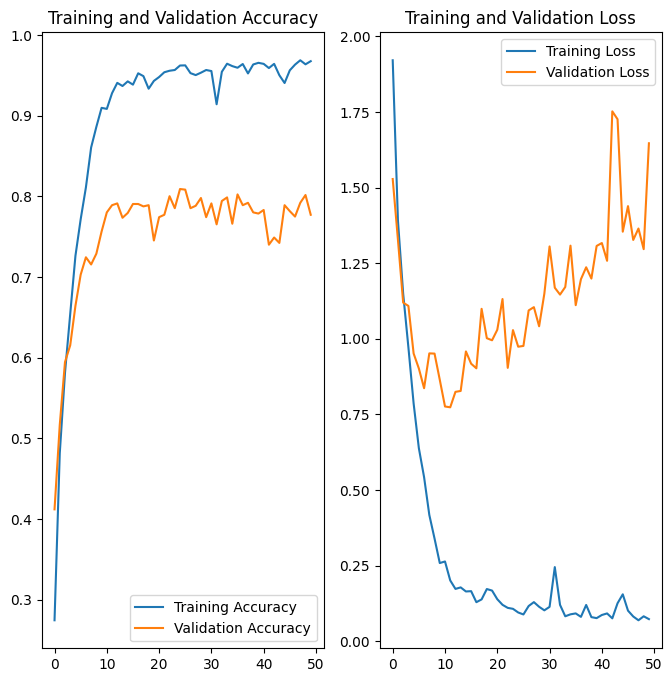

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

